# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
1. *`/datasets/geo_data_0.csv.`*
2. *`/datasets/geo_data_1.csv.`*
3. *`/datasets/geo_data_2.csv.`*

Описание столбцов:
* *`id`* — уникальный идентификатор скважины;
* *`f0, f1, f2`* — три признака точек (неважно, что они означают, но сами признаки значимы);
* *`product`* — объём запасов в скважине (тыс. баррелей).

# Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

**Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.**

## Загрузка и подготовка данных

### Импорт библиотек

In [ ]:
# Загружаем все необходимые данные
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
# Установим константу
RANDOM_STATE = 42

In [ ]:
# Активируется по окончанию проекта
# Проигнорируем предупреждения о возможных изменения работы функций в будущих версиях в Pandas
warnings.filterwarnings("ignore")

### Загрузка данных

In [ ]:
# Загружаем данные с возможностью загрузить их с сервера в случае недоступности локальных файлов
try:
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data0 = pd.read_csv('https://***/datasets/geo_data_0.csv')
    data1 = pd.read_csv('https://***/datasets/geo_data_1.csv')
    data2 = pd.read_csv('https://***datasets/geo_data_2.csv')

### Изучение данных

In [ ]:
# Объявляем функцию для изучения всей информации об датафрейме
def df_review(df, name):
    print('Краткое содержание датафрейма', name)
    display(df.head())
    print('='*100)
    print('Информация о датафрейме', name)
    df.info()
    print('='*100)
    print('Размер датафрейма', name, ':', df.shape)
    print('='*100)
    print('Охарактеризация числовых данных датафрейма', name)
    display(df.drop('id', axis=1).describe().T)
    print('='*100)
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())

In [ ]:
# Обзор датафрейма data0
df_review(data0, 'data0')

Краткое содержание датафрейма data0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Информация о датафрейме data0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер датафрейма data0 : (100000, 5)
Охарактеризация числовых данных датафрейма data0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количество явных дубликатов в датафрейте data0 : 0
Количество пропусков в датафрейте data0 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
# Обзор датафрейма data1
df_review(data1, 'data1')

Краткое содержание датафрейма data1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Информация о датафрейме data1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер датафрейма data1 : (100000, 5)
Охарактеризация числовых данных датафрейма data1


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количество явных дубликатов в датафрейте data1 : 0
Количество пропусков в датафрейте data1 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
# Обзор датафрейма data2
df_review(data2, 'data2')

Краткое содержание датафрейма data2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Информация о датафрейме data2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Размер датафрейма data2 : (100000, 5)
Охарактеризация числовых данных датафрейма data2


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количество явных дубликатов в датафрейте data2 : 0
Количество пропусков в датафрейте data2 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


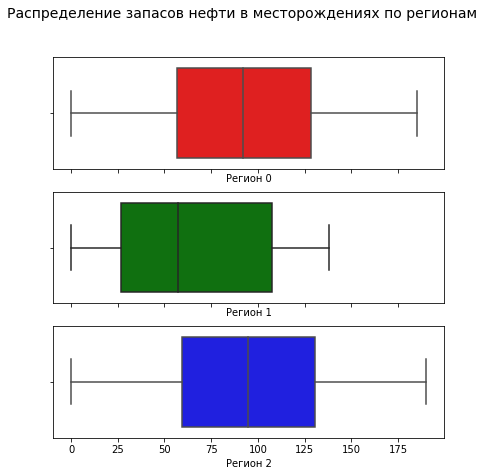

In [ ]:
# Выведем "ящики с усами" по распределению запасов нефти в каждом регионе
fig, axes = plt.subplots(3,1, sharex=True, figsize=(7,7))

sns.boxplot(data0['product'], ax=axes[0], color='red')
sns.boxplot(data1['product'], ax=axes[1], color='green')
sns.boxplot(data2['product'], ax=axes[2], color='blue')

axes[0].set_xlabel('Регион 0')
axes[1].set_xlabel('Регион 1')
axes[2].set_xlabel('Регион 2')

fig.suptitle('Распределение запасов нефти в месторождениях по регионам', size=14)
plt.show()

### Вывод по данным

* Все данные успешно загружены.
* Все типы данных проверены.
* Все столбцы имеют единый формат.
* Дубликаты в данных не обнаружены.
* Пропуски в данных отсутствуют.
* По графикам распределений можно заметить, что запасы нефти в месторождениях на Регионе 1 меньше, чем в остальных регионах.

## Обучение и проверка модели

### Обучение модели

In [ ]:
# Объявляем функцию подготовки данных и обучения модели
def LinModel(data):
    # Отделяем целевой признак от основной выборки
    features = data.drop(['product','id'],axis = 1)
    target = data['product']
    # Делим выборки на тренировочные и валидационные
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size = 0.25, random_state=RANDOM_STATE)
    # Обучаем модель
    model = LinearRegression(n_jobs=-1).fit(features_train, target_train)
    # Собираем предсказания модели
    predictions = model.predict(features_valid)
    # Подготавливаем метрику
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse ** 0.5
    # Среднее запас сырья в регионе
    stock_mean = data['product'].mean()
    stock_mean_pred = predictions.mean()

    target_valid = target_valid.reset_index(drop=True)

    return predictions, rmse, stock_mean_pred, target_valid

In [ ]:
# Обучаем модели по каждому региону
predictions_0, rmse_0, stock_mean_pred_0, target_valid_0 = LinModel(data0)
predictions_1, rmse_1, stock_mean_pred_1, target_valid_1 = LinModel(data1)
predictions_2, rmse_2, stock_mean_pred_2, target_valid_2 = LinModel(data2)

### Проверка модели

In [ ]:
# Выводим показатели по модели региона 0
print('Метрика RMSE модели по региону 0 = {:.2f}'.format(rmse_0))
print('Среднее предсказание запаса сырья в регионе 0 = {:.2f} тыс. баррелей'.format(stock_mean_pred_0))
print('Реальный средний запас сырья в регионе 0 = {:.2f} тыс. баррелей'.format(target_valid_0.mean()))

Метрика RMSE модели по региону 0 = 37.76
Среднее предсказание запаса сырья в регионе 0 = 92.40 тыс. баррелей
Реальный средний запас сырья в регионе 0 = 92.33 тыс. баррелей


In [ ]:
# Выводим показатели по модели региона 1
print('Метрика RMSE модели по региону 1 = {:.2f}'.format(rmse_1))
print('Среднее предсказание запаса сырья в регионе 1 = {:.2f} тыс. баррелей'.format(stock_mean_pred_1))
print('Реальный средний запас сырья в регионе 1 = {:.2f} тыс. баррелей'.format(target_valid_1.mean()))

Метрика RMSE модели по региону 1 = 0.89
Среднее предсказание запаса сырья в регионе 1 = 68.71 тыс. баррелей
Реальный средний запас сырья в регионе 1 = 68.73 тыс. баррелей


In [ ]:
# Выводим показатели по модели региона 2
print('Метрика RMSE модели по региону 2 = {:.2f}'.format(rmse_2))
print('Среднее предсказание запаса сырья в регионе 2 = {:.2f} тыс. баррелей'.format(stock_mean_pred_2))
print('Реальный средний запас сырья в регионе 2 = {:.2f} тыс. баррелей'.format(target_valid_2.mean()))

Метрика RMSE модели по региону 2 = 40.15
Среднее предсказание запаса сырья в регионе 2 = 94.77 тыс. баррелей
Реальный средний запас сырья в регионе 2 = 95.15 тыс. баррелей


###  Выводы по модели

* Все модели успешно обучены.
* Самая лучшая модель получилась по региону 1(RMSE = **0.89 тыс. баррелей**), обе другие модели регионов 0 и 2 имеют метрику RMSE равную **37.76 и 40.15 тыс. баррелей** соответственно.
* Средний запас сырья в 0 и 2 регионах гораздо больше, чем в регионе 1.

## Подготовка к расчёту прибыли

### Переменные с ключевыми значениями

In [ ]:
# Сохраним все ключевые значения для расчётов в переменные
# Бюджет 10 млрд. рублей
budget = 10000000000
# Количество точек при разведке 500
total_points = 500
# Количество лучших точек для разработки 200
best_points = 200
# Доход с каждой единицы продукта составляет 450 тыс. рублей
prise = 450000

### Расчёты объёма сырья

In [ ]:
# Расчитаем средний объём сырья для безубыточно празработки новой скважины в тыс. баррелей
required_volume_mean = budget / best_points / prise
round(required_volume_mean, 2)

111.11

In [ ]:
# Расчитаем общий объём сырья для безубыточной разработки в регионе на 200 месторождений в тыс. баррелей
required_volume_sum = budget / prise
round(required_volume_sum)

22222

### Вывод по подготовке к расчётам прибыли

* Чтобы месторождение отбило себестоимость разработки - необходимо, чтобы в среднем в скважинах было больше 111.1 тыс. баррелей сырья. Средний объем в скважинах всех месторождений ниже этой отметки, что говорит о том, что нам необходимо выбрать наиболее выгодные точки в каждом месторождении и уже их сравнивать между собой.
* Важно учитывать, что средние отклонения посчитаны на выборках размером в 10 тыс. точек. Физически же компания способна разведать не боллее 500 точек в каждом регионе, а разработать всего 200 лучших из них.

### Функция расёта прибыли

In [ ]:
# Объявляем функцию расчета прибыли
def revenue(target, prediction, count):
    probs_sorted = prediction.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (prise * selected.sum() - budget)

## Расчёт прибыли и рисков

### Расчёт прибыли

In [ ]:
# Расчитаем прибыль в каждом регионе
print('Прибыль региона 0: {:.2f} млн. рублей'.format(revenue(target_valid_0, pd.Series(predictions_0),200)/10**6))
print('Прибыль региона 1: {:.2f} млн. рублей'.format(revenue(target_valid_1, pd.Series(predictions_1),200)/10**6))
print('Прибыль региона 2: {:.2f} млн. рублей'.format(revenue(target_valid_2, pd.Series(predictions_2),200)/10**6))

Прибыль региона 0: 3359.14 млн. рублей
Прибыль региона 1: 2415.09 млн. рублей
Прибыль региона 2: 2598.57 млн. рублей


### Расчёт рисков

In [ ]:
state = np.random.RandomState(RANDOM_STATE)

In [ ]:
# Объявляем функцию расчёта средней прибыли для 1000 различных вариантов разведки
def bootstrap(target,probabilities, name):
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace = True, random_state = state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, 200))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    chance_loss = (values < 0).mean()
    interval = (round(values.quantile(0.025)), round(values.quantile(0.975)))
    mean = values.mean()
    print('='*80)
    print(name)
    print('Средняя прибыль:{:.3f} млн. рублей'.format(mean/10**6))
    print('Доверительный интервал среднего:{}'.format(interval))
    print('2.5%-квантиль:{:.3f} млн. рублей'.format(lower/10**6))
    print('Риск:{:.2%}'.format(chance_loss))
    print('='*80)

In [ ]:
# Рассчитаем среднюю прибыль для 1000 различных вариантов разведки
bootstrap(target_valid_0, pd.Series(predictions_0), 'Регион 0')
bootstrap(target_valid_1, pd.Series(predictions_1), 'Регион 1')
bootstrap(target_valid_2, pd.Series(predictions_2), 'Регион 2')

Регион 0
Средняя прибыль:427.848 млн. рублей
Доверительный интервал среднего:(-97249830, 954215193)
2.5%-квантиль:-97.250 млн. рублей
Риск:5.50%
Регион 1
Средняя прибыль:511.530 млн. рублей
Доверительный интервал среднего:(91700564, 921455668)
2.5%-квантиль:91.701 млн. рублей
Риск:0.60%
Регион 2
Средняя прибыль:408.546 млн. рублей
Доверительный интервал среднего:(-120624873, 960859441)
2.5%-квантиль:-120.625 млн. рублей
Риск:7.50%


### Вывод по расчёту прибыли

**Самым прибыльным регионом для разработки можно считать Регион 1**:
* Средняя прибыль **выше** примерно **на 80 млн. рублей**,чем в остальных регионах.
* Риск меньше 1%, что в разы меньше, чем в остальных регионах.

## Общий вывод

Во время над проектом было проделана следующая работа:
* Все данные успешно загружены и изучены:
  * Все типы данных проверены.
  * Все столбцы имеют единый формат.
  * Дубликаты в данных не обнаружены.
  * Пропуски в данных отсутствуют.
  * По графикам распределений можно заметить, что запасы нефти в месторождениях на Регионе 1 меньше, чем в остальных регионах.
* Все моедил успешно построены:
  * Все данные успешно подготовлены.
  * Самая лучшая модель получилась по региону 1(RMSE = **0.89 тыс. баррелей**), обе другие модели регионов 0 и 2 имеют метрику RMSE равную **37.76 и 40.15 тыс. баррелей** соответственно.
  * Вывод по запасам сырья в регионах подтверждён. Средний запас сырья в 0 и 2 регионах гораздо больше, чем в регионе 1.
* Подготовка к расчёту прибыли успешно проведена:
  * Чтобы месторождение отбило себестоимость разработки - необходимо, чтобы в среднем в скважинах было больше 111.1 тыс. баррелей сырья. Средний объем в скважинах всех месторождений ниже этой отметки, что говорит о том, что нам необходимо выбрать наиболее выгодные точки в каждом месторождении и уже их сравнивать между собой.
  * Важно учитывать, что средние отклонения посчитаны на выборках размером в 10 тыс. точек. Физически же компания способна разведать не боллее 500 точек в каждом регионе, а разработать всего 200 лучших из них.
  * Для расёта прибыли объявлена функция.
* Расчёты прибыли и рисков успешно проведены:
  * Общая прибыль регионов посчитана:
    * Прибыль региона 0: 3359.14 млн. рублей.
    * Прибыль региона 1: 2415.09 млн. рублей.
    * Прибыль региона 2: 2598.57 млн. рублей.
  * Средняя прибыль и риски регионов посчитаны:
    * Средняя прибыль региона 0: 427.848 млн. рублей, риск 5.50%.
    * Средняя прибыль региона 1: 511.530 млн. рублей, риск 0.60%.
    * Средняя прибыль региона 2: 408.546 млн. рублей, риск 7.50%.   
    
**Самым прибыльным регионом для разработки можно считать Регион 1:**
* **Средняя прибыль выше примерно на 80 млн. рублей**,чем в остальных регионах.
* **Риск меньше 1%**, что в разы меньше, чем в остальных регионах.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован